* Обучить СНС с помощью Transfer Learning на датасете Food-101
* Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.

******************

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from collections import defaultdict
import os
from shutil import copy
from tqdm import tqdm
import imageio
from skimage.transform import resize

In [3]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.6.0
/device:GPU:0


# Load data. Preprocessig

In [4]:
tfds.disable_progress_bar()
(train_ds, test_ds), ds_info = tfds.load(
    'food101',
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

In [5]:
# для аугментации 
def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in tqdm(classes_images.keys()):
        if not os.path.exists(os.path.join(dest, food)):
            os.makedirs(os.path.join(dest, food))
        for i in classes_images[food]:
            copy(os.path.join(src, food, i), os.path.join(dest, food, i))
    print("Copying Done!")

In [6]:
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:48<00:00,  1.07s/it]

Copying Done!


In [7]:
labels = []
with open('labels.txt', 'r') as f:
    for line in f:
        labels.append(line.rstrip())

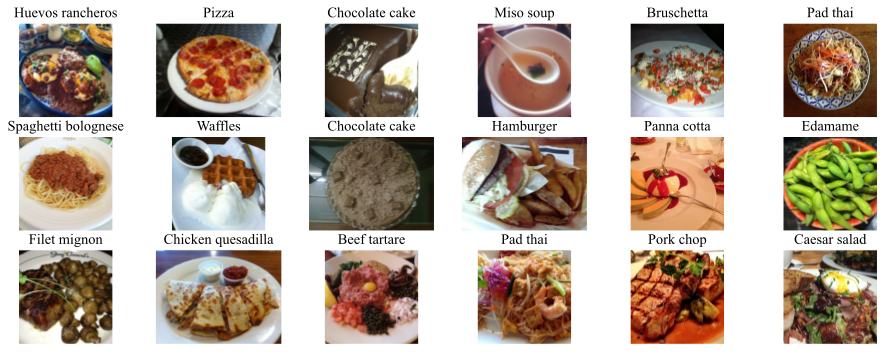

In [8]:
sample = [x for x in iter(train_ds.take(18))]
N = len(sample)
fig = plt.figure(figsize=(16, 8))
for j in range(len(sample)):
    ax = fig.add_subplot(4, 6, j+1)
    ax.imshow(sample[j][0])
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[sample[j][1]])
    plt.grid(False)
plt.show()

In [9]:
INP_SIZE = 160
NUM_EPOCHS = 6
BATCH_SIZE = 32


def prepare(img, label):
    img = tf.cast(img, tf.float32)/255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label


train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

In [10]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1./255
)

# Test model function

In [11]:
def model_test(exp: str = 'transfer_trainable_true', augmentation=False):

    if exp == 'scratch' or exp == 'transfer_trainable_false':
        train_param = False
    else:
        train_param = True

    if exp == 'scratch':
        weights = None
    else:
        weights = 'imagenet'

    # **************************************************************************
    base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        input_shape=(INP_SIZE, INP_SIZE, 3),
        include_top=False,
        weights=weights
    )
    base_model.trainable = train_param

    # **************************************************************************
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(101, activation='softmax'),
    ])
    # **************************************************************************
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir='logs/'+exp,
        write_graph=False, update_freq=100, profile_batch=0)

    # **************************************************************************
    if augmentation:
        train_generator = datagen.flow_from_directory('food-101/train',
                                                      target_size=(
                                                          INP_SIZE, INP_SIZE),
                                                      batch_size=16,
                                                      class_mode='sparse')

        history = model.fit(train_generator,
                            epochs=NUM_EPOCHS,
                            validation_data=test_ds,
                            workers=4)

    else:
        history = model.fit(
            train_ds,
            epochs=NUM_EPOCHS,
            validation_data=test_ds,
            callbacks=[tensorboard_callback])

  
    return model

## InceptionResNetV2: FINE-tuning + augmentation
**по условию задания**

In [12]:
model_tl = model_test(augmentation=True)

Found 75750 images belonging to 101 classes.
Epoch 1/6
4735/4735 [==============================] - 2101s 439ms/step - loss: 2.3571 - accuracy: 0.4427 - val_loss: 1.4942 - val_accuracy: 0.6755
Epoch 2/6
4735/4735 [==============================] - 2115s 447ms/step - loss: 1.4475 - accuracy: 0.6354 - val_loss: 1.4340 - val_accuracy: 0.7419
Epoch 3/6
4735/4735 [==============================] - 2082s 440ms/step - loss: 1.1068 - accuracy: 0.7140 - val_loss: 1.2351 - val_accuracy: 0.8022
Epoch 4/6
4735/4735 [==============================] - 2072s 438ms/step - loss: 0.8690 - accuracy: 0.7702 - val_loss: 1.2410 - val_accuracy: 0.8318
Epoch 5/6
4735/4735 [==============================] - 2064s 436ms/step - loss: 0.6953 - accuracy: 0.8112 - val_loss: 1.2678 - val_accuracy: 0.8543
Epoch 6/6
4735/4735 [==============================] - 2069s 437ms/step - loss: 0.5798 - accuracy: 0.8413 - val_loss: 0.7591 - val_accuracy: 0.8889


In [13]:
model_tl.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               25957     
Total params: 54,756,165
Trainable params: 54,695,621
Non-trainable params: 60,544
_________________________________________________________________


In [14]:
def prepare_image(img):
    img = img.astype(np.float32)/255.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

In [15]:
test_img_labels = ['Apple_pie', 'Bibimbap', 'Cannoli', 'Carrot_cake', 'Churros', 'Edamame',
                  'Oysters', 'Paella', 'Pho', 'Prime_rib', 'Ravioli', 'Tuna_tartare']
img_to_show = []
pred_labels = []
for img in test_img_labels:
    img = imageio.imread(os.path.join('test_pred', img.lower()+'.jpg'), pilmode="RGB")
    img_to_show.append(img)
    img = prepare_image(img)
    pred = model_tl(img[None, ...], training=False).numpy()[0]
    pred_labels.append(labels[np.argmax(pred)])

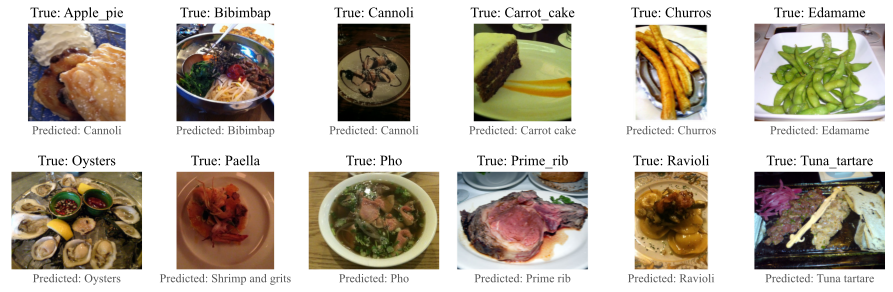

In [16]:
fig = plt.figure(figsize=(16, 10))
for j in range(len(img_to_show)):
    ax = fig.add_subplot(4, 6, j+1)
    plt.subplots_adjust(wspace=0, hspace=0.5)
    ax.imshow(img_to_show[j])
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[sample[j][1]])
    plt.xlabel(f'Predicted: {pred_labels[j]}')
    plt.title(f'True: {test_img_labels[j]}')
    plt.grid(False)
plt.show()